# Projet Télédétection avancée
## Pyrénées 2023-2024
### TUIL Shona 

#### Bibliothèques et fonctions utilisées

In [2]:
import os
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import gdal, ogr
gdal.UseExceptions()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib.colors import ListedColormap

# import libsigma

sys.path.append("/home/onyxia/work/libsigma")
from classification import get_samples_from_roi
import plots

#### Chemins

In [3]:
# répertoire racine des données sources

data = "/home/onyxia/work/data/projet_eval"

# rasters

b3 = os.path.join(data, "pyrenees_23-24_B03.tif")
b5 = os.path.join(data, "pyrenees_23-24_B05.tif")

# echantillons
samples = os.path.join(data, "PI_strates_pyrenees_32630.shp")

# chemins en sortie 
OUT_DIR = "/home/onyxia/work/results"
FIG_DIR = os.path.join(OUT_DIR, "figure")

os.makedirs(OUT_DIR, exist_ok = True)
os.makedirs(FIG_DIR, exist_ok=True)

raster_samples = os.path.join(OUT_DIR, "raster_sample.tif")
raster_ARI = os.path.join(OUT_DIR, "ARI_serie_temp.tif")
ARI_series = os.path.join(FIG_DIR, "ARI_series.png")

In [5]:
# récupération des labels et des dates de la période d'étude

descr_strates = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

dates = [
    "2023-09-25", "2023-09-30", "2023-10-05", "2023-10-07", "2023-10-10",
    "2023-10-12", "2023-11-19", "2023-12-16", "2024-01-25", "2024-03-13",
    "2024-04-12", "2024-05-09", "2024-06-13", "2024-07-23", "2024-08-22"
]

#### Analyse des échantillons

In [6]:
# lecture des échantillons et comptage du nombre de polygones par strates

gdf_samples = gpd.read_file(samples)
samples_valid = gdf_samples[gdf_samples.geometry.notnull()].copy()

champ_strate = "strate"

counts_poly = samples_valid[champ_strate].value_counts().sort_index()
df_poly = pd.DataFrame({
    "strate": counts_poly.index,
    "nb_polygones": counts_poly.values,
    "description": [descr_strates[i] for i in counts_poly.index]
})

In [7]:
# récupération des propriétés géométriques du raster de référence, ici B3

ref_ds = gdal.Open(b3)
gt, proj = ref_ds.GetGeoTransform(), ref_ds.GetProjection()
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize

# création du raster vide

driver = gdal.GetDriverByName("GTiff")
ds_roi = driver.Create(raster_samples, cols, rows, 1, gdal.GDT_Int32)
ds_roi.SetGeoTransform(gt)
ds_roi.SetProjection(proj)
band = ds_roi.GetRasterBand(1)
band.Fill(0)
band.SetNoDataValue(0)

# rasterisation des polygones échantillons, récupération du champ strate pour la valeur des pixels
# ALL_TOUCHED=TRUE pour extraire un maximum de pixels pour chaque strate en incluant les pixels situés en bordure de polygone

vector_ds = ogr.Open(samples)
gdal.RasterizeLayer(ds_roi, [1], vector_ds.GetLayer(), options=[f"ATTRIBUTE={champ_strate}", "ALL_TOUCHED=TRUE"]) 
ds_roi = None

ds_strate = gdal.Open(raster_samples)
arr_strate = ds_strate.GetRasterBand(1).ReadAsArray()
ds_strate = None

# inventaire des classes et calcul de la distribution des pixels

strates_unique = np.unique(arr_strate[arr_strate != 0])
pixels_par_strate = {s: np.sum(arr_strate == s) for s in strates_unique}

# synthèse sous forme de DataFrame
df_pixels = pd.DataFrame({
    "strate": list(pixels_par_strate.keys()),
    "nb_pixels": list(pixels_par_strate.values()),
    "description": [descr_strates[i] for i in pixels_par_strate.keys()]
})

#### Diagrammes du nombre de polygones et du nombre de pixels par strates

In [8]:
# définition des paramètres esthétiques des graphiques

# les couleurs correspondent dans l'ordre aux strates : 1 (Sol Nu), 2 (Herbe), 3 (Landes), 4 (Arbre)
palette_strates = ["#A9A9A9", "#7CFC00", "#9370DB", "#006400"]

bar_width, facecolor_bg = 0.6, "#e0e0e0"
grid_color, grid_width = "#cccccc", 0.5
palette_strates = ["#555555", "#FFD700", "#FF00FF", "#006400"]

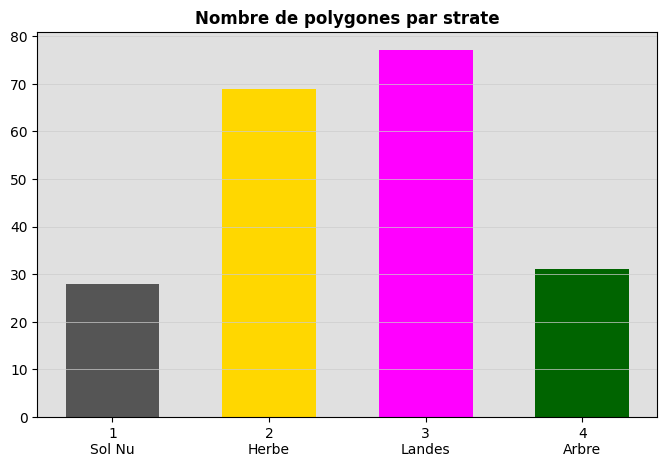

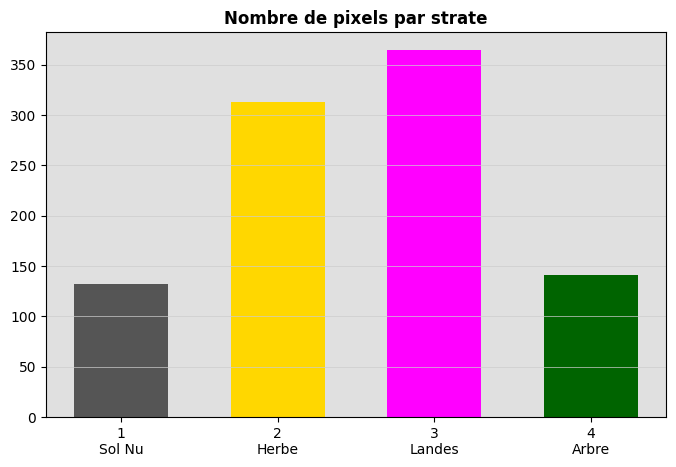

In [9]:
# graphique du nombre de polygones par strates

fig, ax = plt.subplots(figsize=(8,5))
ax.set_facecolor(facecolor_bg)
ax.yaxis.grid(True, color=grid_color, linewidth=grid_width)

# on récupère les paramètres esthétiques définis 

ax.bar(df_poly["strate"], df_poly["nb_polygones"], color=palette_strates, width=bar_width)

ax.set_title("Nombre de polygones par strate", fontweight='bold')
ax.set_xticks(df_poly["strate"])
ax.set_xticklabels([f"{i}\n{descr_strates[i]}" for i in df_poly["strate"]])
plt.savefig(os.path.join(FIG_DIR, "diag_baton_nb_poly_by_class.png"))

plt.show()

# graphique du nombre de pixels par strates
fig, ax = plt.subplots(figsize=(8,5))
ax.set_facecolor(facecolor_bg)
ax.yaxis.grid(True, color=grid_color, linewidth=grid_width)

# on récupère les paramètres esthétiques définis 
ax.bar(df_pixels["strate"], df_pixels["nb_pixels"], color=palette_strates, width=bar_width)

ax.set_title("Nombre de pixels par strate", fontweight='bold')
ax.set_xticks(df_pixels["strate"])
ax.set_xticklabels([f"{i}\n{descr_strates[i]}" for i in df_pixels["strate"]])
plt.savefig(os.path.join(FIG_DIR, "diag_baton_nb_pix_by_class.png"))

plt.show()


##### Analyse de la représentativité de l'échantillonnage 
L'analyse croisée du nombre de polygones et du volume de pixels par strates permet de remarquer : 

- Cohérence de la distribution : On observe une corrélation directe entre les deux indicateurs. Les classes Landes et Herbe sont dominantes (environ 70-80 polygones pour 300-360 pixels), ce qui reflète la réalité écologique de l'étage montagnard et garantit un apprentissage solide des signatures spectrales de ces milieux ouverts.

- Signification du ratio Pixels/Polygone : Avec un ratio moyen d'environ 4 à 5 pixels par polygone, l'échantillonnage témoigne de la fragmentation du paysage pyrénéen. (Ce faible nombre de pixels par unité spatiale souligne l'importance d'activer l'option ALL_TOUCHED=TRUE pour ne perdre aucune information lors de la rasterisation).

- Robustesse des classes minoritaires : Bien que les classes Sol Nu et Arbre disposent d'un effectif plus réduit (environ 30 polygones), elles totalisent plus de 130 pixels chacune. Ce volume est statistiquement suffisant pour que le modèle Random Forest généralise sans risque de sur-apprentissage (overfitting).

- Stratégie de validation : Le déséquilibre numérique entre les classes justifie techniquement l'usage du StratifiedGroupKFold. Cette méthode assure que chaque classe, même minoritaire, est représentée de manière équitable lors de la validation croisée, garantissant ainsi la fiabilité des scores de précision finaux.

### Phénologie des strates, mise en évidence des landes

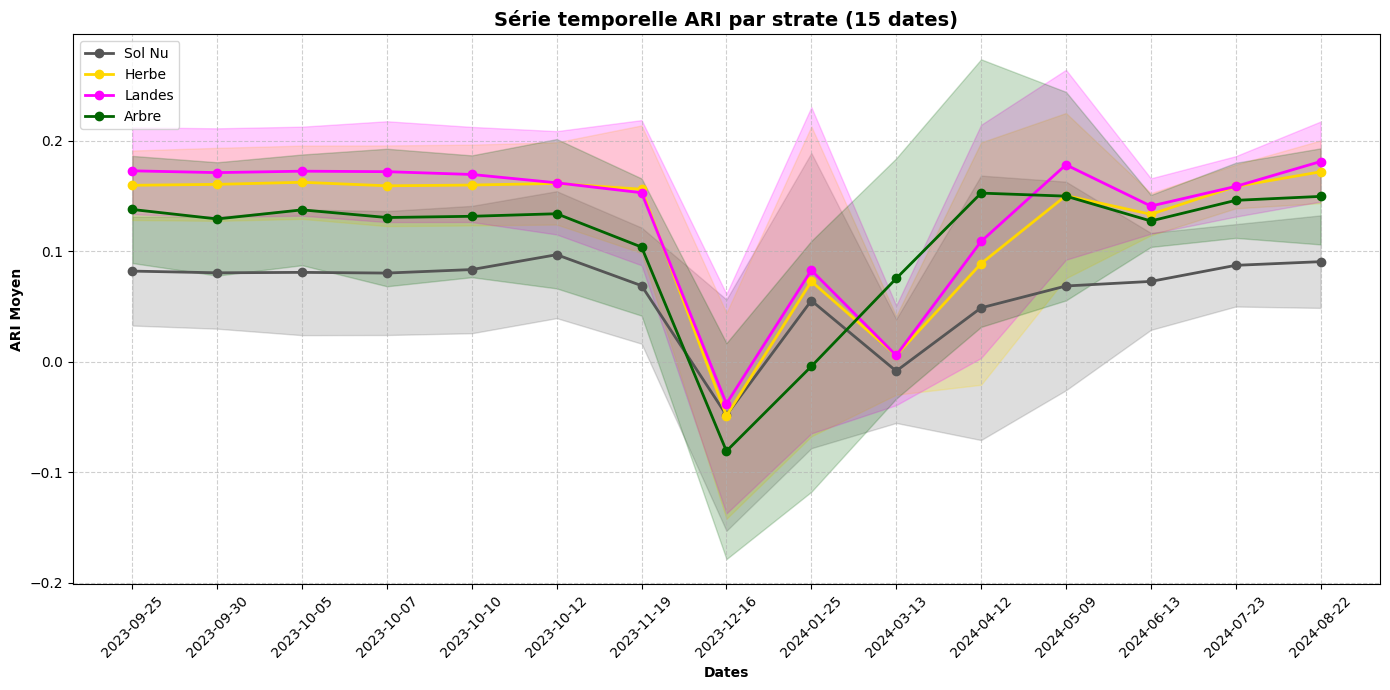

In [10]:
# chargement bandes vert et red-edge

ds_b3 = gdal.Open(b3)
ds_b5 = gdal.Open(b5)
nb_bands = ds_b3.RasterCount

b3_cube = ds_b3.ReadAsArray().astype(np.float32)
b5_cube = ds_b5.ReadAsArray().astype(np.float32)

# utilisation de np.errstate pour ignorer les divisions par zéro sur les zones hors emprise

with np.errstate(divide='ignore', invalid='ignore'):
    inv_b3 = 1 / b3_cube
    inv_b5 = 1 / b5_cube
    ARI_cube = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)

# valeur de no-data

ARI_cube[np.isnan(ARI_cube)] = -9999

# sauvegarde raster ARI
ds_ari = driver.Create(raster_ARI, cols, rows, nb_bands, gdal.GDT_Float32)
ds_ari.SetGeoTransform(gt); ds_ari.SetProjection(proj)
for i in range(nb_bands):
    band_ari = ds_ari.GetRasterBand(i+1)
    band_ari.WriteArray(ARI_cube[i])
    band_ari.SetNoDataValue(-9999)
ds_ari = None

# graphique série temporelle ARI par strate

fig, ax = plt.subplots(figsize=(14, 7))

for c, label in descr_strates.items():
    mask = (arr_strate == c)
    if not np.any(mask): continue
    
    couleur_strate = palette_strates[c-1]
    
    ARI_flat = ARI_cube.reshape(nb_bands, -1)
    masked_data = ARI_flat[:, mask.flatten()]
    masked_data = np.where(masked_data == -9999, np.nan, masked_data)
    
    mean_values = np.nanmean(masked_data, axis=1)
    std_values = np.nanstd(masked_data, axis=1)

    # récupération des paramètres esthétiques 

    ax.plot(dates, mean_values, label=label, marker='o', linewidth=2, color=couleur_strate)
    ax.fill_between(dates, mean_values - std_values, mean_values + std_values, 
                    alpha=0.2, color=couleur_strate)

ax.set_xlabel("Dates", fontweight='bold')
ax.set_ylabel("ARI Moyen", fontweight='bold')
ax.set_title("Série temporelle ARI par strate (15 dates)", fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
ax.legend(loc='upper left', frameon=True)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(ARI_series, dpi=300)
plt.show()


#### Dynamique phénologique de l'indice ARI : 

La série temporelle met en évidence des signatures spectrales distinctes selon les strates, malgré des périodes de recouvrement :

- Saisonnalité marquée : On observe une chute brutale de l'indice ARI pour toutes les classes en décembre 2023, probablement liée à la présence de neige ou à la sénescence hivernale, suivie d'une reprise printanière différenciée à partir d'avril 2024.

- Variabilité inter-classe : La classe Sol Nu (gris) présente systématiquement les valeurs les plus basses, ce qui facilite sa distinction. Les classes Landes (rose) et Herbe (jaune) suivent des trajectoires très proches, suggérant une confusion potentielle que le modèle de classification devra trancher grâce aux autres variables.

- Variabilité intra-classe : Les enveloppes colorées (écarts-types) montrent une dispersion modérée, indiquant que les polygones choisis pour chaque strate sont homogènes et représentatifs de leur classe respective.

#### Classification RF

##### Choix des variables pour la classification
Le choix s'est porté sur un jeu de données de 165 variables, combinant des informations brutes et des indicateurs calculés pour maximiser la précision du modèle :

- L'aspect temporel (15 dates) : L'utilisation des 10 bandes Sentinel-2 répétées sur 15 dates permet de suivre l'évolution de la végétation sur une année complète. C'est un point essentiel dans les Pyrénées, car des milieux comme les pelouses et les landes peuvent avoir des signatures spectrales très proches en été, mais des comportements très différents au moment du débourrement printanier ou de la sénescence automnale. Cette "chronologie" aide le modèle à mieux différencier les strates.

- L'apport de l'indice ARI : En plus des bandes classiques, l'ajout de l'indice ARI apporte une information ciblée sur l'état physiologique des plantes et leur teneur en pigments. Cela sert de "levier" supplémentaire pour le Random Forest : là où les bandes de base atteignent leurs limites pour distinguer deux types de couverts verts, l'ARI permet de mieux percevoir les nuances entre les zones d'arbres, de landes et d'herbe.

In [50]:
# identification des sources et nomenclature des variables (165 variables)
bandes_s2 = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
fichiers_physiques = []
feature_names_full = []

# construction de la pile de données
# on parcourt chaque bande spectrale pour vérifier son existence et nommer les variables
for b in bandes_s2:
    path = os.path.join(data, f"pyrenees_23-24_{b}.tif")
    if os.path.exists(path):
        fichiers_physiques.append(path)
        # generation des noms de variables
        for d in dates:
            feature_names_full.append(f"{b}_{d}")

# vérification de l'alignement géométrique (Dimensions et Résolution)
print(f"Référence attendue : {cols}x{rows} px | Résolution : {abs(gt[1])}m")

for path in fichiers_physiques:
    ds_check = gdal.Open(path)
    # Validation de la structure matricielle par rapport au raster de référence
    if ds_check.RasterXSize != cols or ds_check.RasterYSize != rows:
        print(f" attention : {os.path.basename(path)} présente un défaut d'alignement !")
    else:
        # Confirmation de la conformité spatiale
        print(f"{os.path.basename(path)} : OK")
    
    ds_check = None # Libération de la ressource

Référence attendue : 2103x1655 px | Résolution : 10.0m
pyrenees_23-24_B02.tif : OK
pyrenees_23-24_B03.tif : OK
pyrenees_23-24_B04.tif : OK
pyrenees_23-24_B05.tif : OK
pyrenees_23-24_B06.tif : OK
pyrenees_23-24_B07.tif : OK
pyrenees_23-24_B08.tif : OK
pyrenees_23-24_B8A.tif : OK
pyrenees_23-24_B11.tif : OK
pyrenees_23-24_B12.tif : OK


In [51]:
# ajout de l'indice ARI à la pile de données

if os.path.exists(raster_ARI):
    fichiers_physiques.append(raster_ARI)
    for d in dates:
        feature_names_full.append(f"ARI_{d}")

# création du raster virtuel multi-temporel
# option separate=True place chaque fichier dans une bande distincte

vrt_stack = os.path.join(OUT_DIR, "stack_temp.vrt")
gdal.BuildVRT(vrt_stack, fichiers_physiques, separate=True)

# extraction des données d'entraînement
# X contiendra les valeurs spectrales (features) et Y les étiquettes (classes)
print(f"Extraction des échantillons (165 variables)...")
X, Y, t = get_samples_from_roi(vrt_stack, raster_samples)

# redimensionnement de Y pour obtenir un vecteur 1D (format attendu par Scikit-Learn)
Y = Y.ravel()

Extraction des échantillons (165 variables)...


#### Justification du choix duStratified GroupKFold comme méthode de validation croisée : 

- L'aspect **"Group"** est indispensable pour contrer le biais spatial induit par l'autocorrélation des données. Comme l'échantillonnage a été réalisé par polygones, les pixels d'une même parcelle sont très similaires (même exposition, même sol, même météo). Si on les mélangeait au hasard, le modèle pourrait retrouver en test des pixels presque identiques à ceux utilisés pour l'entraînement. Ce biais spatial fausserait les résultats en donnant une illusion de haute précision due à une simple mémorisation de voisinage. En utilisant les identifiants de polygones comme groupes, on s'assure qu'un polygone entier sert soit à l'entraînement, soit au test, mais jamais aux deux en même temps. Cela garantit que le modèle est capable de réellement généraliser ses connaissances à de nouvelles zones géographiques qu'il n'a jamais rencontrées.

- L'aspect **"Stratified"** permet de gérer le déséquilibre numérique entre nos classes (par exemple entre les Landes, très représentées, et les Sols Nus). Cette approche garantit que chaque pli de la validation respecte les proportions réelles de chaque strate. Cela évite d'obtenir des scores de précision trompeurs qui ne refléteraient que la performance sur les classes majoritaires au détriment des milieux moins étendus. »

In [53]:
# création d'une couche d'identifiants (ID) pour la validation croisée
# création d'un raster temporaire en mémoire pour associer chaque pixel à son polygone d'origine

ds_id = driver.Create("/vsimem/ids.tif", cols, rows, 1, gdal.GDT_Int32)
ds_id.SetGeoTransform(gt); ds_id.SetProjection(proj)

# chaque pixel hérite du numéro de son polygone

gdal.RasterizeLayer(ds_id, [1], vector_ds.GetLayer(), options=["ATTRIBUTE=id"]) 

# extraction des identifiants pour les associer aux échantillons (X, Y)

groups = ds_id.ReadAsArray()[t].ravel() # on défini les id comme variable pour le stratifiedgroupKfold

# nettoyage de la matrice de données X et déclaration des nodata

X = np.nan_to_num(X, nan=0.0)
X[X == -9999] = 0

X_train, X_test, Y_train, Y_test, groups_train, groups_test = train_test_split(
    X, Y, groups, test_size=0.5, random_state=1, stratify=Y
)

#### On teste plusieurs valeurs pour les hyperparamètres : 
- n_estimators [50 à 300] : L'objectif est de trouver le point d'équilibre entre performance et temps de calcul. On commence à 50 pour voir si un modèle rapide suffit, et on monte jusqu'à 300 car, au-delà, le gain de précision devient souvent négligeable par rapport à la lourdeur du fichier final.

- max_depth [None, 10, 15, 20] : On teste None pour laisser le modèle s'exprimer librement, mais on introduit des limites (10, 15, 20) pour voir si brider la croissance des arbres permet de réduire l'overfitting. En zone de montagne fragmentée, une profondeur modérée aide souvent à mieux généraliser.

- max_features [None, 'sqrt', 'log2'] : Cette plage explore la diversité des arbres. Tester sqrt (racine carrée) et log2 permet de voir si le modèle est plus performant en limitant le nombre de variables par nœud (ce qui réduit la corrélation entre les arbres), tandis que None utilise toutes les variables (165) pour maximiser l'information à chaque étape.

- min_samples_leaf [1, 5] : On compare ici une approche très granulaire (1 pixel suffit pour créer une règle) à une approche plus stable (5 pixels minimum). La valeur 5 permet de lisser les prédictions et d'éviter que le modèle ne soit trop influencé par des pixels isolés ou "bruités" dans les signatures spectrales.

#### Justification de n_splits=3 : 

- Représentativité des classes rares : Ce choix permet de conserver un nombre suffisant de polygones dans chaque "pli" (fold). Avec un k plus élevé, les classes les moins représentées (comme les sols nus) risqueraient de disparaître de certains plis, rendant la validation impossible.

- Stabilité de l'apprentissage : En utilisant un ratio de 2/3 des données pour l'entraînement et 1/3 pour le test, on s'assure que le modèle dispose d'un échantillon assez large pour apprendre la diversité des signatures spectrales des Pyrénées.

- Optimisation du temps de calcul : Le GridSearchCV testant 120 combinaisons différentes sur 165 variables, k=3 offre un excellent compromis entre la rigueur de l'optimisation et la puissance de calcul nécessaire.

- Cohérence avec le GroupKFold : Cette configuration limite les risques d'instabilité liés à la répartition des groupes (polygones), garantissant que chaque évaluation repose sur des bases solides et comparables.

In [54]:
# grille d'optimisation des hyperparamètres à tester

print("Optimisation GridSearchCV (Grille complète)...")
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

# configuration de la cross-validation
# utilisation de StratifiedGroupKFold

cv = StratifiedGroupKFold(n_splits=3)
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=1), 
    param_grid, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1 # Utilisation de tous les processeurs pour accélérer le calcul
)

Optimisation GridSearchCV (Grille complète)...


In [56]:
# le modèle teste chaque combinaison de la grille sur les 3 plis
# 'groups' pour que le StratifiedGroupKFold respecte bien la séparation par polygones.

grid_search.fit(X_train, Y_train, groups=groups_train)
best_rf = grid_search.best_estimator_

# Évaluation par validation croisée
y_pred = cross_val_predict(best_rf, X, Y, groups=groups, cv=cv) # indiquer que l'on veut former les groupes avec le champ id

print(f"\nMEILLEURS PARAMÈTRES : {grid_search.best_params_}")


MEILLEURS PARAMÈTRES : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}


#### Importance des variables

In [ ]:
import pandas as pd

results_df = pd.DataFrame(grid_search.cv_results_)

# renommage des colonnes pour la lisibilité
cols_utiles = {
    'rank_test_score': 'Rang',
    'mean_test_score': 'Accuracy Moyenne',
    'param_n_estimators': 'Arbres',
    'param_max_depth': 'Profondeur',
    'param_max_features': 'Features',
    'param_min_samples_leaf': 'Min Feuilles',
    'mean_fit_time': 'Temps calcul (s)'
}

# création du tableau de synthèse

top_10_df = results_df[list(cols_utiles.keys())].sort_values(by='rank_test_score').head(10)
top_10_df = top_10_df.rename(columns=cols_utiles)

# affichage

print("les 10 meilleurs combinaisons d'hyperparamètres :")
display(top_10_df.style.hide(axis='index').background_gradient(cmap='Greens', subset=['Accuracy Moyenne']))

les 10 meilleurs combinaisons d'hyperparamètres :


Rang,Accuracy Moyenne,Arbres,Profondeur,Features,Min Feuilles,Temps calcul (s)
1,0.903582,50,None,sqrt,1,0.165618
1,0.903582,50,15,sqrt,1,0.154038
1,0.903582,50,20,sqrt,1,0.159135
4,0.898244,100,None,sqrt,1,0.336782
4,0.898244,100,20,sqrt,1,0.322106
6,0.895538,300,10,log2,1,0.685079
7,0.894513,100,10,None,1,2.614598
7,0.894513,100,None,None,1,2.717226
7,0.894513,300,15,None,1,7.874789
7,0.894513,100,15,None,1,2.614039


Nombre d’arbres = 300 : Le modèle utilise 300 arbres pour stabiliser les résultats. Plus il y a d’arbres, plus le modèle est robuste et évite les erreurs aléatoires sur des pixels isolés. C'est le maximum testé, ce qui montre que la complexité des Pyrénées nécessite un grand nombre de "votes" pour être précise.

Profondeur des arbres = None : Les arbres n'ont pas de limite de croissance. Cela permet au modèle de descendre dans un niveau de détail très fin pour distinguer des classes qui se ressemblent spectralement (ex: deux types de forêts ou de prairies).

Variables par nœud = log2 : À chaque étape, l'arbre ne choisit ses critères que parmi un petit nombre de variables (environ 7 sur 165). Cela force le modèle à être plus "intelligent" et varié, ce qui l'empêche de s'appuyer toujours sur les mêmes bandes spectrales et améliore sa capacité à classer de nouvelles zones.

Minimum d’échantillons par feuille = 1 : Le modèle est autorisé à créer des règles très précises, même pour un seul pixel. C'est ce qui permet d'obtenir une excellente précision sur le jeu d'entraînement, car le modèle colle au plus près de la réalité du terrain échantillonné.

Le score de moyenne accuracy de 92,8% correspond à la performance théorique maximale obtenue pendant la phase de réglage du modèle. Il est calculé en faisant la moyenne des scores obtenus sur les différents sous-échantillons d'entraînement. Un score aussi élevé montre que le modèle a parfaitement identifié les signatures spectrales de nos zones d'étude, même s'il peut traduire une légère tendance à l'overfitting.

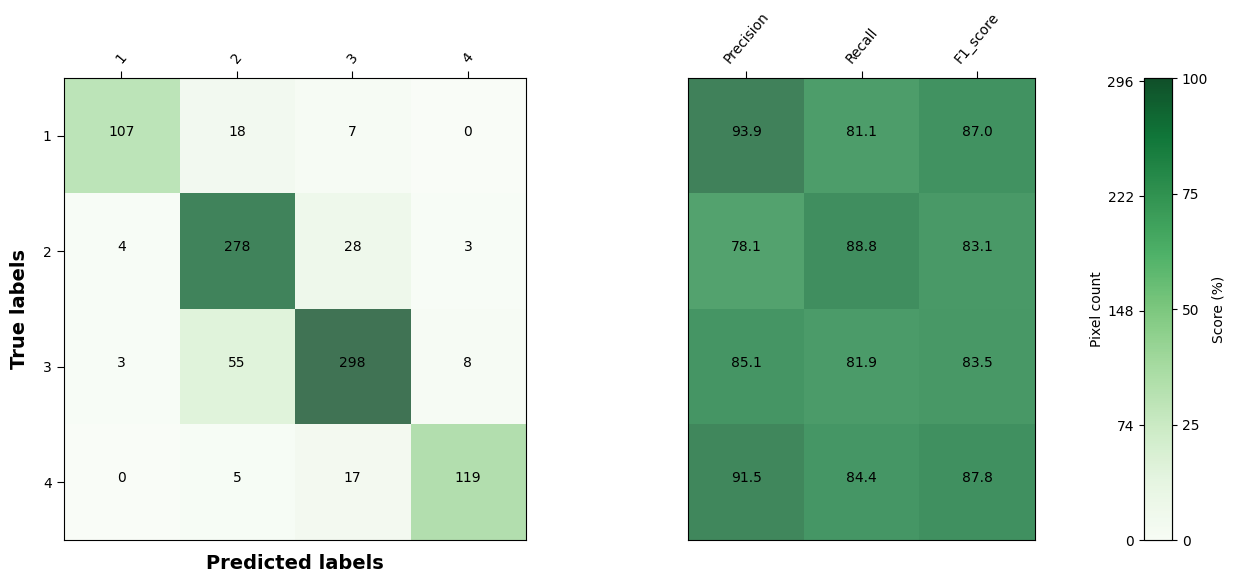

In [ ]:
# matrice de confusion

cm = confusion_matrix(Y, y_pred, labels=np.unique(Y))
plots.plot_cm(cm, np.unique(Y))
plt.show()

La matrice de confusion confirme la pertinence de la stratégie d’échantillonnage adoptée. Les classes majoritaires (Landes et Herbe), bien représentées à la fois en nombre de polygones et en volume de pixels, présentent les meilleures performances de classification, traduisant un apprentissage robuste de leurs signatures spectrales. Les classes minoritaires (Sol nu et Arbre), malgré un effectif polygonal plus faible, conservent des scores de précision et de rappel satisfaisants, ce qui valide le choix d’un échantillonnage assurant un nombre suffisant de pixels par classe. Les principales confusions observées concernent des classes écologiquement proches, plutôt que des effets de sous-représentation, indiquant que les erreurs sont davantage liées à la similarité spectrale qu’à un biais d’échantillonnage. Enfin, l’usage du StratifiedGroupKFold se révèle cohérent avec cette distribution, garantissant une évaluation fiable et équilibrée des performances du modèle.

#### Importance des variables 

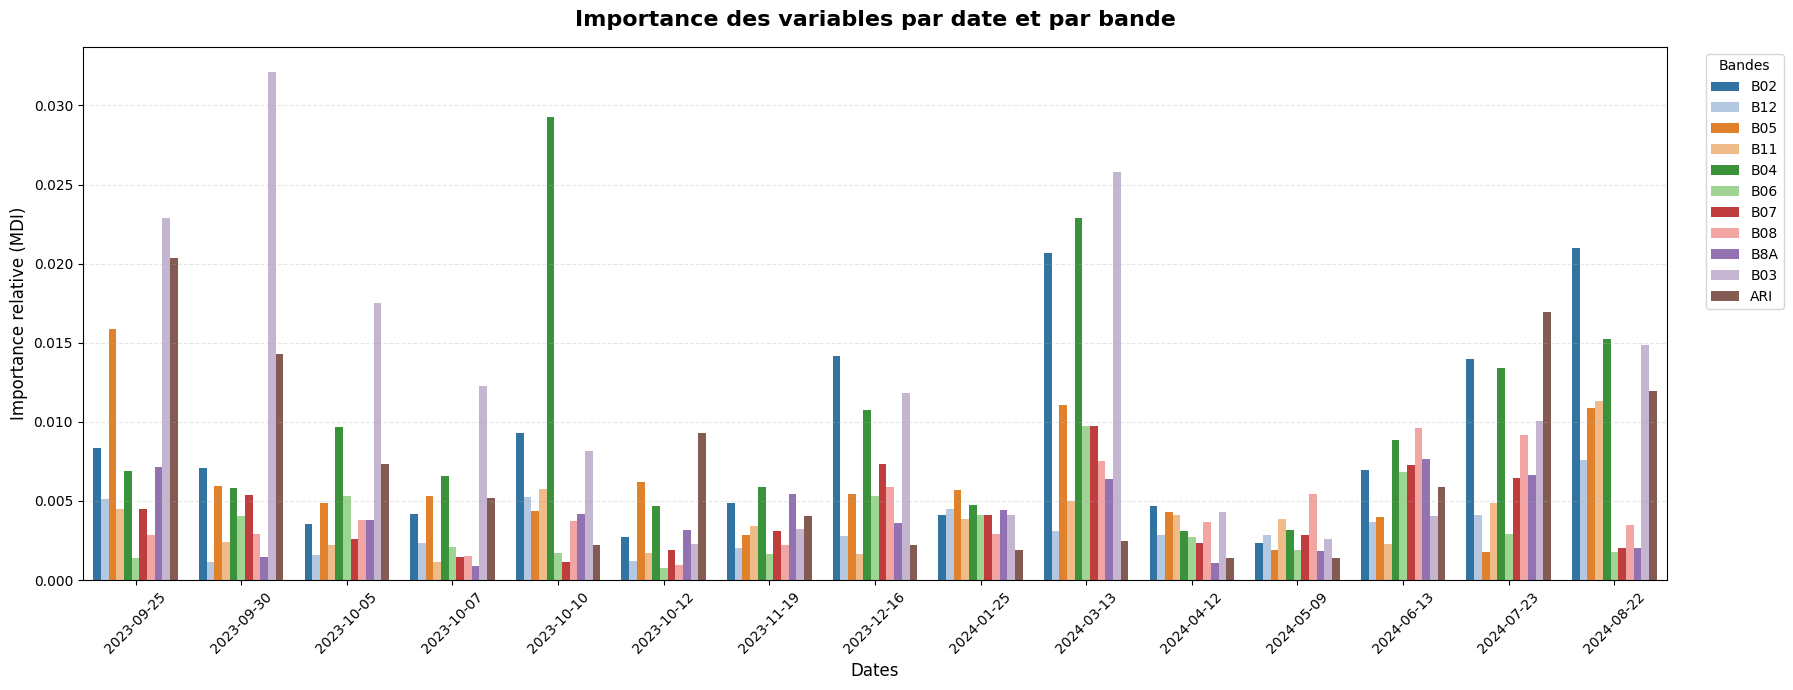

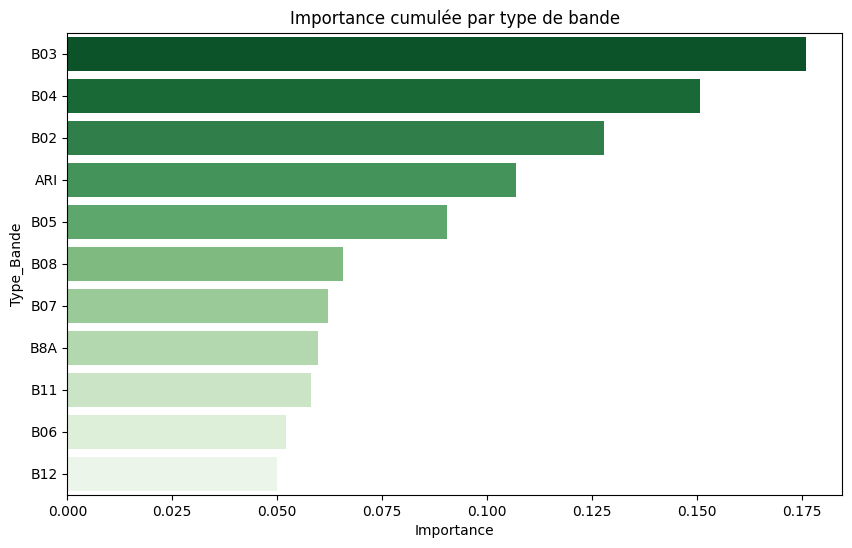

In [64]:
# dataFrame de base

df_imp = pd.DataFrame({
    'Variable': feature_names_full,
    'Importance': best_rf.feature_importances_
})

# séparation Bande / Date

df_imp[['Bande', 'Date']] = df_imp['Variable'].str.split('_', n=1, expand=True)

# trier les dates chronologiquement

df_imp['Date'] = pd.to_datetime(df_imp['Date'])
df_imp = df_imp.sort_values('Date')

plt.figure(figsize=(18, 7))

sns.barplot(
    data=df_imp,
    x='Date',
    y='Importance',
    hue='Bande',
    palette='tab20'
)

plt.title(
    "Importance des variables par date et par bande",
    fontsize=16,
    fontweight='bold',
    pad=15
)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Importance relative (MDI)", fontsize=12)

plt.xticks(rotation=45)
plt.legend(title="Bandes", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()

# synthèse par bande

df_all_imp = pd.DataFrame({'Feature': feature_names_full, 'Importance': best_rf.feature_importances_})

df_all_imp['Type_Bande'] = df_all_imp['Feature'].apply(lambda x: x.split('_')[0])
df_synth = df_all_imp.groupby('Type_Bande')['Importance'].sum().reset_index().sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Type_Bande', data=df_synth, palette='Greens_r', hue='Type_Bande', legend=False)
plt.title("Importance cumulée par type de bande")
plt.show()


Variabilité temporelle des saisons : On observe que l’importance des variables varie fortement selon les dates. Certaines périodes, notamment fin septembre–octobre et fin mars–été, présentent des valeurs d’importance plus élevées pour plusieurs bandes. Cela suggère que la classification tire parti de phases phénologiques clés, où les différences entre classes sont plus discriminantes.

Contribution différenciée des bandes : les bandes B8 (NIR) et B4 (rouge) figurent parmi les variables les plus contributives sur la majorité des dates. Leur importance élevée reflète leur capacité à capter l’état de la végétation (biomasse, vigueur, activité chlorophyllienne), ce qui est crucial pour discriminer les classes étudiées. Les bandes B5, B6 et B7 (red-edge) montrent également des contributions notables, en particulier à certaines dates clés. Leur sensibilité aux variations subtiles de la végétation confirme leur intérêt pour améliorer la performance de la classification, notamment dans des contextes agricoles ou de couvert végétal dense.

L’indice ARI et les bandes visibles (B2, B3) présentent une importance plus modérée mais régulière. Leur contribution semble jouer un rôle complémentaire, apportant des informations supplémentaires sur la structure ou la composition des surfaces, sans être les variables dominantes.

Variabilité inter-bandes et inter-dates : la variabilité observée entre les bandes et les dates souligne l’intérêt d’une approche multi-temporelle et multi-spectrale. Aucune variable ne domine systématiquement l’ensemble des dates, ce qui confirme que la performance du modèle repose sur la combinaison des informations spectrales à différents moments de l’année.

#### Production et affichage de la carte

In [1]:
best_rf.fit(X, Y)

# prédiction sur l'image complète

X_all, _, t_all = get_samples_from_roi(vrt_stack, vrt_stack)
X_all = np.nan_to_num(X_all, nan=0.0)
predictions = best_rf.predict(X_all)

# reconstitution 2D de la carte

carte_raw = np.zeros((rows, cols), dtype=np.uint8)
carte_raw[t_all[0], t_all[1]] = predictions

# masque d'emprise
ds_ref_for_mask = gdal.Open(b3)
arr_ref_mask = ds_ref_for_mask.GetRasterBand(1).ReadAsArray()
ds_ref_for_mask = None 
carte_final_clean = np.where(arr_ref_mask > 0, carte_raw, 0)


map_masked = np.ma.masked_where(carte_final_clean == 0, carte_final_clean)

plt.figure(figsize=(12, 10), facecolor='white')

# récupération des paramètres esthétiques
custom_cmap = ListedColormap(palette_strates)
custom_cmap.set_bad(color='white') 

im = plt.imshow(map_masked, cmap=custom_cmap, vmin=1, vmax=4, interpolation='none')

import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=palette_strates[i], label=descr_strates[i+1]) for i in range(len(palette_strates))]
plt.legend(handles=patches, loc='lower right', title="Strates", frameon=True, fontsize=10)

plt.title(f"Carte Finale des Strates de Végétation (Pyrénées)\nPrécision Globale (OA) : {accuracy_score(Y, y_pred):.2f}", 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('off')

plt.show()

# sauvegarde du fichier TIF final
out_path_tif = os.path.join(OUT_DIR, "carte_strates.tif")
ds_final = driver.Create(out_path_tif, cols, rows, 1, gdal.GDT_Byte)
ds_final.SetGeoTransform(gt); ds_final.SetProjection(proj)
ds_final.GetRasterBand(1).WriteArray(carte_final_clean)
ds_final.GetRasterBand(1).SetNoDataValue(0)
ds_final = None

print(f"TERMINÉ ! Carte enregistrée sous : {out_path_tif}")

NameError: name 'best_rf' is not defined

L'Overall Accuracy de 84% représente la performance concrète du modèle final. Contrairement au score précédent, celui-ci est calculé en testant le modèle sur des polygones géographiques entiers qu'il n'a jamais rencontrés durant son apprentissage (grâce à la méthode StratifiedGroupKFold). L'écart de 9% entre l'entraînement et l'OA est classique en télédétection de milieux naturels complexes comme les Pyrénées : il montre que le modèle reste robuste (supérieur à 80%) tout en perdant un peu de précision lorsqu'il doit généraliser ses connaissances à de nouveaux secteurs géographiques.